In [1]:
import os
import pandas as pd
import numpy as np
import logging
import datetime
import joblib
import mlflow.keras
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from ml_investing_wne.xtb.xAPIConnector import APIClient, APIStreamClient, loginCommand
from ml_investing_wne.data_engineering.prepare_dataset import prepare_processed_dataset
import ml_investing_wne.config as config
from ml_investing_wne.train_test_val_split import train_test_val_split
from ml_investing_wne.helper import confusion_matrix_plot, compute_profitability_classes, check_hours
from ml_investing_wne.data_engineering.load_data import get_hist_data
import importlib
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2022-10-23 14:46:52.059441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-23 14:46:52.059495: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import random
import tensorflow as tf
from ml_investing_wne.utils import get_logger
seed = 12345
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
                   
logger = get_logger()

In [3]:
df = get_hist_data(currency=config.currency)
df = prepare_processed_dataset(df=df)
X, y, X_val, y_val, X_test, y_test, y_cat, y_val_cat, y_test_cat, train = train_test_val_split(df)

[2022-10-23 14:47:18,444][prepare_processed_dataset:89] exported to /home/jupyter/ml_investing_wne/src/ml_investing_wne/data/processed/EURCHF/EURCHF_processed_720min.csv
2022-10-23 14:47:18,444 - ml_investing_wne.data_engineering.prepare_dataset - exported to /home/jupyter/ml_investing_wne/src/ml_investing_wne/data/processed/EURCHF/EURCHF_processed_720min.csv
[2022-10-23 14:47:18,470][split_sequences:24] first sequence begins: 2010-01-24 12:00:00
2022-10-23 14:47:18,470 - ml_investing_wne.train_test_val_split - first sequence begins: 2010-01-24 12:00:00
[2022-10-23 14:47:18,472][split_sequences:25] first sequence ends: 2010-03-25 00:00:00
2022-10-23 14:47:18,472 - ml_investing_wne.train_test_val_split - first sequence ends: 2010-03-25 00:00:00
[2022-10-23 14:47:18,499][split_sequences:30] last sequence begins: 2019-10-30 12:00:00
2022-10-23 14:47:18,499 - ml_investing_wne.train_test_val_split - last sequence begins: 2019-10-30 12:00:00
[2022-10-23 14:47:18,501][split_sequences:31] last

In [4]:
model = load_model(os.path.join(config.package_directory, 'models', 'production',
                        '{}_{}_{}_{}_{}_{}'.format(config.model, 'hist_data',
                                                   config.currency, config.freq,
                                                   str(config.steps_ahead),
                                                   config.seq_len)))

y_pred = model.predict(X_test)

if 'JPY' in config.currency:
    scalar = 100
else:
    scalar = 10000

2022-10-23 14:47:21.864323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-23 14:47:21.864366: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-23 14:47:21.864391: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20220811): /proc/driver/nvidia/version does not exist
2022-10-23 14:47:21.864646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 14:47:24.035255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of

In [5]:
df['cost'] = (config.pips/scalar)/df['close']
start_date = joblib.load(os.path.join(config.package_directory, 'models',
                                           'first_sequence_ends_{}_{}_{}.save'.format('test', config.currency, config.freq)))
end_date = joblib.load(os.path.join(config.package_directory, 'models',
                                           'last_sequence_ends_{}_{}_{}.save'.format('test', config.currency, config.freq)))


naive_forecast = df.loc[df['datetime']<config.train_end].copy()

#naive_forecast = df.loc[df['datetime']>datetime.datetime(2019,1,1)]
naive_forecast['datetime_london'] = naive_forecast['datetime'].dt.tz_localize('US/Eastern').dt.tz_convert(
    'Europe/London').dt.tz_localize(None)
# make it so that time represents end of interval, not beginning
naive_forecast['datetime_london'] = naive_forecast['datetime_london'] + pd.Timedelta(minutes=int(re.findall("\d+", config.freq)[0]))
naive_forecast['hour_london'] = naive_forecast['datetime_london'].dt.time
naive_forecast['pips_difference'] = (naive_forecast['close'].shift(-config.steps_ahead) - naive_forecast['close'])*scalar
naive_forecast_group = naive_forecast.groupby('hour_london')['y_pred'].mean()
naive_forecast_group
naive_predictor = round(naive_forecast_group).to_dict()


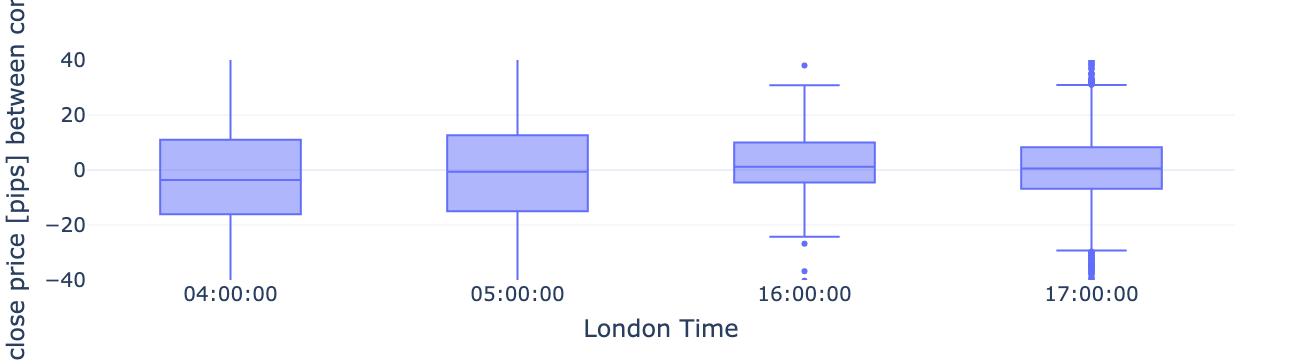

In [7]:
# hours_to_include = [datetime.time(2,0,0),datetime.time(22,0,0),datetime.time(22,0,0), datetime.time(10,0,0),
#                     datetime.time(14,0,0), datetime.time(18,0,0), datetime.time(6,0,0)]
hours_to_include = [datetime.time(5,0,0),datetime.time(17,0,0)]

naive_forecast = naive_forecast.sort_values(by='hour_london')
#naive_forecast = naive_forecast.loc[naive_forecast['hour_london'].isin(hours_to_include)]
#  px.box(naive_forecast.loc[(abs(naive_forecast['pips_difference'])<=100) ],

fig = px.box(naive_forecast,
             x="hour_london", y="pips_difference",

             labels={
                 "pips_difference": "Difference in close price [pips] between consecutive hours",
                 "hour_london": "London Time"
             }
             )
fig.update_layout(
    template='plotly_white',
    yaxis=dict(
        range=[-40, 40]
    ),
    font=dict(size=20)
    # ,title={
    #     'text': "{} Training set - {} interval".format(config.currency,config.freq),
    #     'y':0.95,
    #     'x':0.5,
    #     'xanchor': 'center',
    #     'yanchor': 'top'}
    )
fig.show()
fig.write_image(os.path.join(config.package_directory, 'models','{}_{}_box_plot_training.png'.format(config.currency, config.freq)), width=1200, height=800)


In [8]:
fig = px.box(naive_forecast.loc[(df['datetime']>=datetime.datetime(2019,1,1)) & (df['datetime']<datetime.datetime(2020,1,1))],
             x="hour_london", y="pips_difference",
             labels={
                 "pips_difference": "Difference in close price [pips] between consecutive hours",
                 "hour_london": "London Time"
             }
             )
fig.update_layout(
    template='plotly_white',
    font=dict(size=20),
    yaxis=dict(
        range=[-40, 40]
    ),
    title={
        'text': "{} Training set (2019) - {} interval".format(config.currency, config.freq),
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#fig.show()
fig.write_image(os.path.join(config.package_directory, 'models','{}_{}_box_plot_training_2019.png'.format(config.currency, config.freq)), width=1200, height=800)


In [9]:
prediction = check_hours(df, y_pred, start_date, end_date, lower_bound=0.5, upper_bound=0.5)

Distribution by hour
hour_london
04:00:00    0.444444
05:00:00    0.509025
16:00:00    0.400000
17:00:00    0.478261
Name: change, dtype: float64
Distribution by hour for prediction
             count   success
hour_london                 
04:00:00        18  0.611111
05:00:00       277  0.566787
16:00:00        15  0.400000
17:00:00       230  0.652174


In [10]:

prediction.rename(columns={'hour_london':'London Time'}, inplace=True)
prediction['naive_forecast'] = prediction['London Time'].map(naive_predictor)
prediction['naive_accuracy'] = 0
prediction.loc[((prediction['naive_forecast'] == 1) & (prediction['y_pred'] > 0)) |
               ((prediction['naive_forecast'] == 0) & (prediction['y_pred'] < 0)), 'naive_accuracy'] = 1

pred_accuracy = prediction.loc[prediction['trade'] != 0.5].groupby('London Time').agg(count=('trade', 'size'),
                                                                             correct_prediction=('success', 'mean'))
pred_accuracy.reset_index(inplace=True)
pred_accuracy['prediction_type'] = 'model'
naive_accuracy = prediction.groupby('London Time').agg(count=('trade', 'size'),
                                                                             correct_prediction=('naive_accuracy', 'mean'))
naive_accuracy.reset_index(inplace=True)
naive_accuracy['prediction_type'] = 'naive'
naive_accuracy.correct_prediction.mean()
df_to_plot = pd.concat([pred_accuracy, naive_accuracy])
df_to_plot = df_to_plot.loc[df_to_plot['London Time'].isin(hours_to_include)]
fig = px.bar(df_to_plot, x="London Time", y="correct_prediction", color='prediction_type',barmode='group',
             labels={
                 "correct_prediction": "Accuracy",
                 "London Time": " ",
                 "prediction_type": "Prediction type"
             }
             )
fig.update_layout(
    # title={
    #     'text': "{} Test set- {} interval".format(config.currency, config.freq),
    #     'y':0.95,
    #     'x':0.5,
    #     'xanchor': 'center',
    #     'yanchor': 'top'},
    # font=dict(size=18),
    font=dict(
        size=20
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    template='plotly_white')
fig.write_image(os.path.join(config.package_directory, 'models','{}_{}_naive_forecast.png'.format(config.currency, config.freq)), width=1200, height=800)


In [24]:
prediction['pips_difference'] = (prediction['close'].shift(-config.steps_ahead) - prediction['close'])*10000
prediction = prediction.sort_values(by='London Time')
prediction = prediction.loc[prediction['London Time'].isin(hours_to_include)]
fig = px.box(prediction, x="London Time", y="pips_difference",
             labels={
                 "pips_difference": "Difference in close price [pips] between consecutive hours",
                 "London Time": " "
             }
             )
fig.update_layout(
    template='plotly_white',
    font=dict(size=18),
    yaxis=dict(
        range=[-40, 40]
    )
    # ,title={
    #     'text':  "{} Test set - {} interval".format(config.currency,config.freq),
    #     'y':0.95,
    #     'x':0.5,
    #     'xanchor': 'center',
    #     'yanchor': 'top'}
)
#fig.show()
fig.write_image(os.path.join(config.package_directory, 'models','EURCHF_{}_box_plot_testset.png'.format(config.freq)), width=1200, height=800)


In [10]:
hours_to_exclude = [datetime.time(21,0,0), datetime.time(22,0,0),  datetime.time(23,0,0)]
excluded_hours_df = prediction.loc[~prediction['London Time'].isin(hours_to_exclude)].copy()

correct = excluded_hours_df.loc[((excluded_hours_df['prediction'] > 0.55) & (excluded_hours_df['y_pred'] > 0)) |
               ((excluded_hours_df['prediction'] < 0.45) & (excluded_hours_df['y_pred'] < 0))].shape[0]

all_predictions = excluded_hours_df.loc[(excluded_hours_df['prediction'] > 0.55) | (excluded_hours_df['prediction'] < 0.45)].shape[0]

correct/all_predictions

0.5834076717216771

In [21]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [24]:
excluded_hours_df.loc[(excluded_hours_df['prediction'] > 0.55) | (excluded_hours_df['prediction'] < 0.45)].sort_values(by='datetime').shape

(1049, 53)

In [17]:
excluded_hours_df.datetime.min(), excluded_hours_df.datetime.max(), 

(Timestamp('2021-01-03 18:00:00'), Timestamp('2021-12-24 14:00:00'))

In [11]:
def compute_profitability_classes(df, y_pred, date_start, date_end, lower_bound, upper_bound, time_waw_list=None):
    prediction = df.copy()
    prediction.reset_index(inplace=True)
    df['y_pred'] = df['close'].shift(-config.steps_ahead) / df['close'] - 1
    # new_start = config.val_end + config.seq_len * datetime.timedelta(minutes=int(''.join(filter(str.isdigit, config.freq))))
    prediction = df.loc[(df.datetime >= date_start) & (df.datetime <= date_end)]
    prediction['datetime_waw'] = prediction['datetime'].dt.tz_localize('US/Eastern').dt.tz_convert(
        'Europe/Warsaw').dt.tz_localize(None)
    prediction['hour_waw'] = prediction['datetime_waw'].dt.time
    # prediction['trade'] = y_pred.argmax(axis=1)
    prediction['prediction'] = y_pred[:, 1]
    conditions = [
        (prediction['prediction'] <= lower_bound),
        (prediction['prediction'] > lower_bound) & (prediction['prediction'] <= upper_bound),
        (prediction['prediction'] > upper_bound)
    ]
    values = [0, 0.5, 1]
    prediction['trade'] = np.select(conditions, values)
    if time_waw_list:
        prediction.loc[~prediction['hour_waw'].isin(time_waw_list), 'trade'] = 0.5
    prediction.reset_index(inplace=True)
    budget = 100
    transaction = None
    i = 0
    # drop last row for which we don't have a label
    prediction.drop(prediction.tail(1).index, inplace=True)
    while i < prediction.shape[0]:
        # for i in range(prediction.shape[0]):
        if prediction.loc[i, 'trade'] == config.nb_classes - 1:
            # add transaction cost if position changes
            if transaction != 'buy':
                # initally I assumed that cost can be beared twice, but with spread as only cost it should count only once
                if not transaction:
                    budget = budget * (1 - prediction.loc[i, 'cost'])
                else:
                    budget = budget * (1 - prediction.loc[i, 'cost'])
            transaction = 'buy'
            budget = budget + budget * prediction.loc[i, 'y_pred']
            prediction.loc[i, 'budget'] = budget
            prediction.loc[i, 'transaction'] = transaction
            i = i + config.steps_ahead
        elif prediction.loc[i, 'trade'] == 0:
            # add transaction cost if position changes
            if transaction != 'sell':
                if not transaction:
                    budget = budget * (1 - prediction.loc[i, 'cost'])
                else:
                    budget = budget * (1 - (1 * prediction.loc[i, 'cost']))
            transaction = 'sell'
            budget = budget + budget * (-prediction.loc[i, 'y_pred'])
            prediction.loc[i, 'budget'] = budget
            prediction.loc[i, 'transaction'] = transaction
            i = i + config.steps_ahead
        elif prediction.loc[i, 'trade'] == 0.5:
            if transaction in ['buy', 'sell']:
                # budget = budget * (1 - prediction.loc[i, 'cost'])
                transaction = None
            prediction.loc[i, 'budget'] = budget
            prediction.loc[i, 'transaction'] = transaction
            i = i + 1

    hits = prediction.loc[((prediction['transaction'] == 'buy') & (prediction['y_pred'] > 0)) |
                          ((prediction['transaction'] == 'sell') & (prediction['y_pred'] < 0))].shape[0]
    transactions = prediction.loc[prediction['transaction'].isin(['buy', 'sell'])].shape[0]
    try:
        hits_ratio = hits / transactions
    except ZeroDivisionError:
        hits_ratio = 0
    share_of_time_active = round(prediction.loc[prediction['transaction'].isin(['buy', 'sell'])].shape[0] * \
                                 config.steps_ahead / prediction.shape[0], 2)
    logger.info('share_of_time_active for bounds {}-{} is {} and hit ratio is {}'.format(lower_bound, upper_bound,
                                                                                         share_of_time_active,
                                                                                         hits_ratio))
    logger.info('Portfolio result:  {}'.format(budget))

    return budget, hits_ratio, share_of_time_active, prediction

In [13]:
df['cost'] = (0/10000)/df['close']
_,_,_, prediction = compute_profitability_classes(df, y_pred, start_date, end_date, 0.5, 0.5)
prediction.rename(columns={'budget':'no cost'}, inplace=True)
prediction_chart = prediction[['datetime','close','no cost']].copy()

df['cost'] = (2/10000)/df['close']
_,_,_, prediction = compute_profitability_classes(df, y_pred, start_date, end_date, 0.5, 0.5)
prediction.rename(columns={'budget':'cost - 2 pips'}, inplace=True)
prediction_chart = prediction_chart.merge(prediction[['datetime','cost - 2 pips']], on='datetime')


df['cost'] = (4/10000)/df['close']
_,_,_, prediction = compute_profitability_classes(df, y_pred, start_date, end_date, 0.5, 0.5)
prediction.rename(columns={'budget':'cost - 4 pips'}, inplace=True)
prediction_chart = prediction_chart.merge(prediction[['datetime','cost - 4 pips']], on='datetime')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [14]:

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(template='plotly_white')
fig.add_trace(go.Scatter(x=prediction_chart['datetime'], y=prediction_chart['no cost'], name='no cost',
                    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=prediction_chart['datetime'], y=prediction_chart['cost - 2 pips'], name='cost - 2 pips',
                    line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=prediction_chart['datetime'], y=prediction_chart['cost - 4 pips'], name='cost - 4 pips',
                    line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=prediction_chart['datetime'], y=prediction_chart['close'], name=config.currency,
                    line=dict(color='gold', width=4)),
              secondary_y=True)
fig.update_yaxes(title_text="Portfolio evolution - index", secondary_y=False)
fig.update_yaxes(title_text=config.currency, secondary_y=True)
# fig.update_layout(
#     title={
#         'text': 'Model based on {} interval'.format(config.freq),
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})

fig.write_image(os.path.join(config.package_directory, 'models','{}_{}_portfolio_5-5.png'.format(config.currency,config.freq)))
